In [1]:
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [2]:
import pandas as pd

file_name = "household_power_consumption.txt"  # mets ici le vrai nom

df = pd.read_csv(
    file_name,
    sep=";",                 # séparateur ;
    decimal=".",             # séparateur décimal .
    na_values="?",           # dans ce dataset, les valeurs manquantes sont "?"
)

In [4]:
df.head()
# Date Time sont séparées, nous allon sles combiner, pour qu'elle soit plus adaptée au fonctionnalités predefinies de panda, qui fonctionne avec datetime comme index

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
# Combiner Date + Time en une seule colonne datetime
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

# Mettre datetime en index (optionnel mais pratique)
df = df.set_index("datetime")

In [6]:
df.head()
# La combinaison à terminée

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
# Nous allons vérifier si tous les champs sont remplies
df.isna().sum()
# Remarque d'absence de 25979 valeurs pour quelques colonnes
# Nosu décidons de les supprimer car nous avons plus de 2M lignes, et 25979 fait 1% de la taille du Dataset

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [12]:
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Nous supprimons les lignes où les mesures sont NaN
df = df.dropna(subset=num_cols)

df.isna().sum()
# Maintenant, nous n'avons aucune ligne avec valeur manquante


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [13]:
len(df)
# 2 075 259 - 25 979 = 2 049 280

2049280

In [14]:
# Dans la phase de netoyyage, nous allons nous assurer que tous les champs chiffres sont numériques
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[num_cols].dtypes  # pour vérifier que c'est bien float64

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [15]:
# Global_active_power est en kW mesuré chaque minute.
# Pour obtenir l'énergie consommée pendant chaque minute (en kWh),
# nous multiplions par la durée en heures : 1 minute = 1/60 heure → donc division par 60.
df["energy_kwh"] = df["Global_active_power"] / 60.0

In [16]:
#   - Pour les puissances et la tension, nous prenons la moyenne quotidienne.
#   - Pour les compteurs d'énergie (sub_metering_1/2/3) et energy_kwh, nous faisons la somme sur la journée.
# Création d'un nouveau Dataset Daily, qui match bien la forme de l'API consommée
daily = df.resample("D").agg({
    "Global_active_power": "mean",      # Puissance active moyenne (kW) par jour
    "Global_reactive_power": "mean",    # Puissance réactive moyenne (kVAR) par jour
    "Voltage": "mean",                  # Tension moyenne (V)
    "Global_intensity": "mean",         # Intensité moyenne (A)
    "Sub_metering_1": "sum",            # Énergie journalière (Wh) sur le compteur 1
    "Sub_metering_2": "sum",            # Énergie journalière (Wh) sur le compteur 2
    "Sub_metering_3": "sum",            # Énergie journalière (Wh) sur le compteur 3
    "energy_kwh": "sum"                 # Énergie totale journalière (kWh) = variable cible principale
})


In [19]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh
datetime,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933
2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667
2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433
2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800


In [29]:
# 4) Nous renommons, juste comme bonne pratique la colonne datetime en date, car elle ne comporte pas le time
daily = daily.rename(columns={"datetime": "date"})

In [22]:
len(daily)
# 1442 lignes, pour notre objectif tracée, relation de la météo journalière et la type de jour ( week end, jours ferié , jour normal )

1442

In [31]:
# S'assurer que la colonne de date est en datetime
daily["date"] = pd.to_datetime(daily["date"])

In [32]:
# Jour de la semaine (0 = lundi, 6 = dimanche)
daily["jour_semaine"] = daily["date"].dt.dayofweek

In [34]:
# Nom du jour (pour les graphiques)
daily["jour_nom"] = daily["date"].dt.day_name()

In [36]:
# Week-end : samedi (5) et dimanche (6)
daily["is_weekend"] = daily["jour_semaine"].isin([5, 6])

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,jour_semaine,jour_nom,is_weekend
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,5,Saturday,True
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,6,Sunday,True
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,0,Monday,False
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,1,Tuesday,False
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2,Wednesday,False


In [38]:
!pip install holidays
import pandas as pd
import holidays
# Jours fériés français (2006–2010)
fr_holidays = holidays.France(years=[2006, 2007, 2008, 2009, 2010])
daily["is_holiday"] = daily["date"].apply(lambda d: d in fr_holidays)

In [42]:
daily[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]].head(15)
# Maintenant, nous avons pour chaque ligne, est ce que c'est un week end ?
# ou c'est un jours ferié,
# les jours normaux sont les jours dont weekend = false et holyday = false


,date,jour_nom,is_weekend,is_holiday,energy_kwh
0,2006-12-16,Saturday,True,False,20.152933
1,2006-12-17,Sunday,True,False,56.507667
2,2006-12-18,Monday,False,False,36.730433
3,2006-12-19,Tuesday,False,False,27.769900
4,2006-12-20,Wednesday,False,False,37.095800
5,2006-12-21,Thursday,False,False,28.610400
6,2006-12-22,Friday,False,False,39.022300
7,2006-12-23,Saturday,True,False,79.556433
8,2006-12-24,Sunday,True,False,42.500200
9,2006-12-25,Monday,False,True,45.718667


In [50]:
daily.nlargest(10, "energy_kwh")[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]]
# Dejà une remarque avant même d'aller à la météo, les TOP 1 sont generalement des week ends en hiver

,date,jour_nom,is_weekend,is_holiday,energy_kwh
7,2006-12-23,Saturday,True,False,79.556433
49,2007-02-03,Saturday,True,False,67.162033
10,2006-12-26,Tuesday,False,False,65.568500
64,2007-02-18,Sunday,True,False,63.829367
50,2007-02-04,Sunday,True,False,59.932333
57,2007-02-11,Sunday,True,False,59.520467
105,2007-03-31,Saturday,True,False,58.491833
15,2006-12-31,Sunday,True,False,58.236600
85,2007-03-11,Sunday,True,False,58.010600
36,2007-01-21,Sunday,True,False,56.787700


In [52]:
# Mois numérique (1 = janvier, ..., 12 = décembre)
daily["mois"] = daily["date"].dt.month

# Nom du mois (Janvier, Février, ...)
daily["mois_nom"] = daily["date"].dt.month_name()

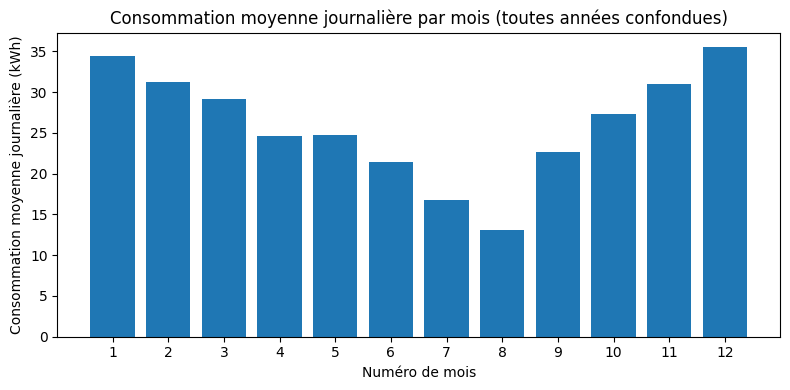

In [57]:
# Affichage d'un graphe pour indiquer la relation entre le mois ( froid ou chaud ) et la consommation
import matplotlib.pyplot as plt

moyenne_par_mois = (
    daily.groupby("mois")[["energy_kwh"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.bar(moyenne_par_mois["mois"], moyenne_par_mois["energy_kwh"])
plt.xticks(range(1, 13))
plt.xlabel("Numéro de mois")
plt.ylabel("Consommation moyenne journalière (kWh)")
plt.title("Consommation moyenne journalière par mois (toutes années confondues)")
plt.tight_layout()
plt.show()

In [59]:
import requests
import pandas as pd


# Période couverte par vos données, pour passer à l'API, en relation avec le tableau comme plage
date_min = daily["date"].min().strftime("%Y-%m-%d")
date_max = daily["date"].max().strftime("%Y-%m-%d")

# Coordonnées de Sceaux (France) selons le site web https://www.gps-longitude-latitude.net/
lat, lon = 48.78, 2.29
# Liste des données que nous voulons
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": date_min,
    "end_date": date_max,
    "daily": [
        "temperature_2m_mean",
        "temperature_2m_min",
        "temperature_2m_max",
        "precipitation_sum",
        "daylight_duration",
        "sunshine_duration",
    ],
    "timezone": "Europe/Paris",
}
# Consommation de l'API
resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# Création du DataFrame météo,
weather = pd.DataFrame(data["daily"])
# Convertir en Date
weather["date"] = pd.to_datetime(weather["time"])
# Suppression de colone time, elle est imposé par l'API, obligé de la notoyé ici
weather = weather.drop(columns=["time"])

weather.head()

,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,date
0,6.2,3.3,8.4,3.8,29825.21,0.00,2006-12-16
1,3.0,-0.2,7.1,0.0,29797.73,19535.07,2006-12-17
2,3.1,1.2,5.2,0.9,29775.72,7489.45,2006-12-18
3,1.8,0.6,4.2,0.0,29759.19,24686.46,2006-12-19
4,1.2,-0.8,4.8,0.0,29748.15,24821.37,2006-12-20


In [61]:
# Etape importante, le Merge entre API et Dataset, cette ligne doit petre executée une seule fois sinon nous allons avoir 2 colonnes
# et pd change le nom des colonnes automatiquement, avec _x et _y
daily = daily.merge(weather, on="date", how="left")

In [69]:
# Vérification du forme du tableau
daily.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,jour_semaine,...,is_weekend,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,5,...,True,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,6,...,True,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,0,...,False,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,1,...,False,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2,...,False,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37


In [71]:
# Convertir le nombre de secondes entre lever et coucher de solein en heures
daily["daylight_hours"] = daily["daylight_duration"] / 3600.0

In [72]:
daily.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,jour_semaine,...,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,daylight_hours
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,5,...,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00,8.284781
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,6,...,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07,8.277147
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,0,...,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45,8.271033
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,1,...,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46,8.266442
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2,...,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37,8.263375


/tmp/ipython-input-1502701557.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  moy_par_bin = daily.groupby("temp_bin")["energy_kwh"].mean().reset_index()


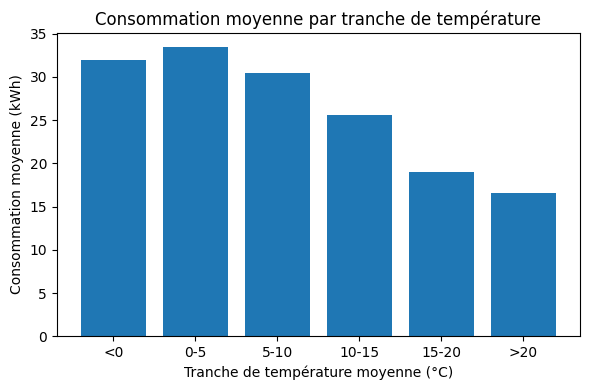

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

bins = [-10, 0, 5, 10, 15, 20, 30]
labels = ["<0", "0-5", "5-10", "10-15", "15-20", ">20"]
daily["temp_bin"] = pd.cut(daily["temperature_2m_mean"], bins=bins, labels=labels, include_lowest=True)

moy_par_bin = daily.groupby("temp_bin")["energy_kwh"].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.bar(moy_par_bin["temp_bin"], moy_par_bin["energy_kwh"])
plt.xlabel("Tranche de température moyenne (°C)")
plt.ylabel("Consommation moyenne (kWh)")
plt.title("Consommation moyenne par tranche de température")
plt.tight_layout()
plt.show()

# ça nous aide encore à créer avoir une idée de relation entre froid et consommation.